## Predicting Functional Threshold Power (FTP)

In [897]:
import os
import pandas as pd
import strava_export as strava
from tabulate import tabulate as tab

athletes = pd.read_csv(os.path.join(strava.pro_dir, 'athletes.csv'))
rides = pd.read_csv(
    os.path.join(strava.pro_dir, 'rides.csv'), 
    parse_dates=['timestamp'], 
    infer_datetime_format=True
)

print(tab(athletes, headers='keys', tablefmt='psql', showindex='false'))
print('Total rides: {:,}'.format(len(rides_all)))
print('Ride variables: {:,}'.format(len(list(rides))))
# print(*list(rides), sep='\n')

+-------------+---------+------------+-------+----------+-------------+
| firstname   |      id | lastname   | sex   |   weight |   num_rides |
|-------------+---------+------------+-------+----------+-------------|
| Alun        | 2163639 | Hanford    | M     |       68 |         225 |
| David       | 6377876 | Rich       | M     |       72 |         164 |
| James       | 4917647 | Kinley     | M     |       68 |         239 |
+-------------+---------+------------+-------+----------+-------------+
Total rides: 628
Ride variables: 25


## Data Exploration
* Discussion of certain features about the dataset (inc. samples)
* Report and discussion of statistics about the dataset
* Discussion of any abnormalities or characteristics that need to be addressed (e.g. categorical variables, missing values, or outliers)

In [898]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def fliers(series):
    '''Outlier detection using Tukey's Method'''
    series = series.fillna(0)
    q1 = np.percentile(series, 25.)
    q3 = np.percentile(series, 75.)
    tk_step = (q3-q1)*1.5
    return series[(series < q1-tk_step) | (series > q3+tk_step)]    

def num_outliers(series):
    '''Number of outliers in series'''    
    return len(fliers(series))

def explore_report(df, cols, plot=True):
    print(tab(df[cols].describe(), headers='keys', tablefmt='psql', floatfmt='.2f'))

    stats = defaultdict(list)
    for c in cols:
        series = df[c]
        stats[c].append(sum(series.isna()))
        stats[c].append(100/len(series)*sum(series.isna()))
        stats[c].append(round(series.skew(),2))
        stats[c].append(num_outliers(series))

    stats_pd = pd.DataFrame.from_dict(stats)
    stats_pd.rename(index={0:'nan', 1:'nan_perc', 2:'skew', 3:'outliers'}, inplace=True)
    print(tab(stats_pd, headers='keys', tablefmt='psql', floatfmt='.2f'))
    
    if plot:
        axes = df[cols].hist(alpha=0.5, bins=50, color='#333e47', figsize=(12, 8), grid=False)
        for ax in axes:    
            for x in ax:
                x.spines['right'].set_visible(False)
                x.spines['top'].set_visible(False)
        plt.show()

Explore **cadence** & **heart rate**

**Cadence**
* `88%` of rides have cadence data (good coverage)
* IQR is narrow but within expected ranges
* `max_cadence` max of `246` is physically difficult to reach, so possibly a sensor or other data anomoly (fixed by removing the `134` outliers)
* Both cadence features have minimal skew

**Heart Rate**
* Only `54%` of rides have heart rate data. Not all athletes wear a heart rate monitor for every ride, if at all, so this is expected. Heart rate is a key indication of effort, so despite the poor coverage it shouldn't be removed
* Statistics seem sensible and within expected ranges. Max heart rate of `214` is rare, but not physically impossible
* Marginally higher skew than the cadence features, but not enough to be concered about


+-------+---------------+---------------+------------------+------------------+
|       |   avg_cadence |   max_cadence |   avg_heart_rate |   max_heart_rate |
|-------+---------------+---------------+------------------+------------------|
| count |        550.00 |        550.00 |           337.00 |           337.00 |
| mean  |         80.05 |        114.61 |           140.80 |           165.27 |
| std   |         11.54 |         28.17 |            16.92 |            18.80 |
| min   |          5.00 |          9.00 |             0.00 |             0.00 |
| 25%   |         77.00 |        100.00 |           133.00 |           157.00 |
| 50%   |         82.00 |        110.00 |           142.00 |           168.00 |
| 75%   |         86.00 |        121.00 |           149.00 |           177.00 |
| max   |        101.00 |        246.00 |           178.00 |           214.00 |
+-------+---------------+---------------+------------------+------------------+
+----------+---------------+------------

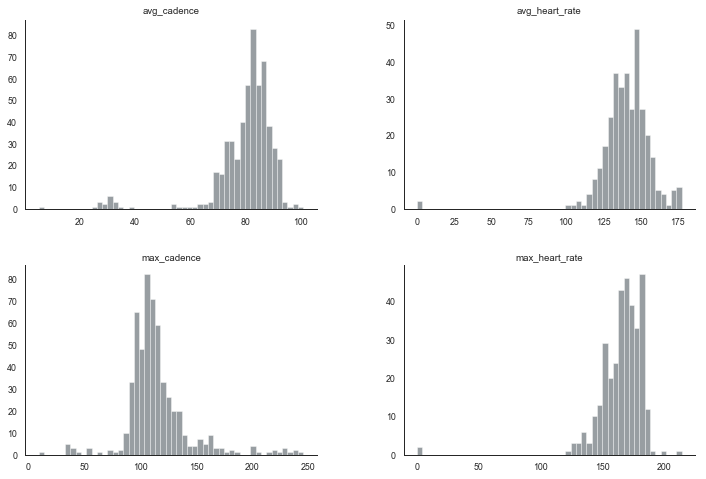

In [899]:
# explore cadence & heart rate
explore_report(
    rides,
    ['avg_cadence', 
     'max_cadence',
     'avg_heart_rate',
     'max_heart_rate']
)

Explore **power** & **stress**

**Power**
* Only `47%` of rides have power data. Power data is collected from a power meter (strain gauge) attached to a bike, or an indoor "turbo" trainer. Not all athletes have a power meter so poor coverage is expected when using Strava data. More specific cycling applications, such as TrainerRoad, rely on power numbers and will have better coverage
* `max_power` is highly skewed due to the `9` outlying values (max power of 22,276 watts is physically impossible). Removing these outliers should significantly reduce the skew
* `normalized_power` is an important variable. Also known as _weighted average power_ it takes ride variation into account (e.g. terrain, intervals, rest, etc) to provide a better estimate of average power if you had a constant power output for the entire ride. It provides the ability to compare effort between rides
* Considering that the dataset includes accurate `ftp` values (what we're trying to predict), I think Strava's estimated `threshold_power` feature can be omitted

**Stress**
* `training_stress_score` (TSS) is a measure of how hard a ride was. The higher the TSS, the more potential fitness gained from the ride, and the greater need for recovery afterwards [1]. Again, despite the relatively poor coverage, this is an important variable to keep
* `training_stress_score` is highly skewed due to the `27` outlying values, which should be removed

[1] https://science4performance.com/2017/04/20/strava-ride-statistics/

+-------+-------------+-------------+--------------------+-------------------+-------------------------+
|       |   avg_power |   max_power |   normalized_power |   threshold_power |   training_stress_score |
|-------+-------------+-------------+--------------------+-------------------+-------------------------|
| count |      295.00 |      295.00 |             295.00 |            288.00 |                  293.00 |
| mean  |      175.06 |      615.34 |             192.79 |            224.95 |                  111.14 |
| std   |       33.26 |     1781.05 |              36.48 |             48.83 |                  152.81 |
| min   |        1.00 |       64.00 |               6.00 |            200.00 |                    0.00 |
| 25%   |      162.00 |      293.50 |             176.00 |            200.00 |                   52.20 |
| 50%   |      175.00 |      365.00 |             193.00 |            200.00 |                   87.80 |
| 75%   |      189.00 |      584.50 |             208.0

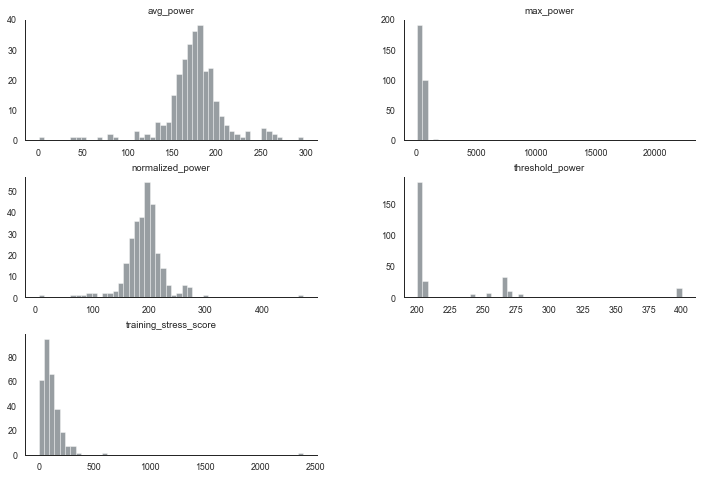

In [900]:
# explore power & stress
explore_report(
    rides,
    ['avg_power', 
     'max_power', 
     'normalized_power', 
     'threshold_power',    
     'training_stress_score']
)

Explore **speed**

* Good coverage and within expected ranges
* Minimal skew
* `enhanced` variables appear to be the same and can be removed
* `avg_speed` has `124` outliers that should be removed
* `max_speed` has `113` outliers that should be removed

+-------+-------------+----------------------+----------------------+-------------+
|       |   avg_speed |   enhanced_avg_speed |   enhanced_max_speed |   max_speed |
|-------+-------------+----------------------+----------------------+-------------|
| count |      628.00 |               628.00 |               529.00 |      529.00 |
| mean  |        6.49 |                 6.49 |                14.06 |       14.06 |
| std   |        3.39 |                 3.39 |                 3.53 |        3.53 |
| min   |        0.00 |                 0.00 |                 0.00 |        0.00 |
| 25%   |        6.11 |                 6.11 |                12.32 |       12.32 |
| 50%   |        7.53 |                 7.53 |                14.63 |       14.63 |
| 75%   |        8.49 |                 8.49 |                16.19 |       16.19 |
| max   |       18.06 |                18.06 |                38.15 |       38.15 |
+-------+-------------+----------------------+----------------------+-------

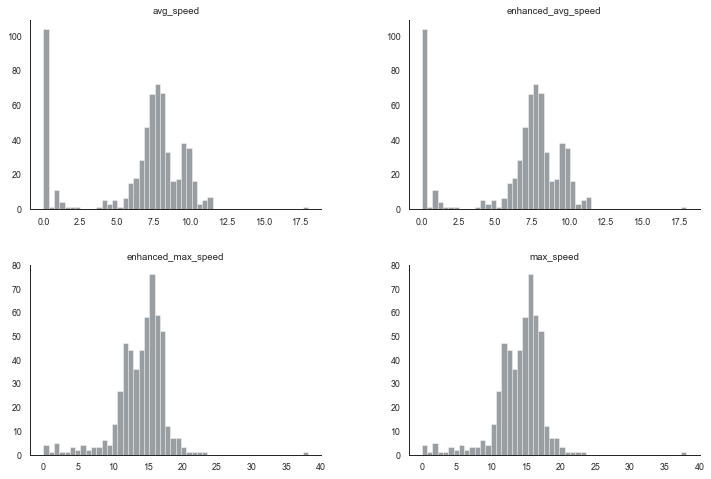

In [901]:
# explore speed
explore_report(
    rides,
    ['avg_speed', 
     'enhanced_avg_speed', 
     'enhanced_max_speed', 
     'max_speed']
)

Explore **totals** (pt1)

* Good coverage and within expected ranges
* Minimal skew
* Small number of outliers to be removed
* `ascent` and `decent` variables have many examples with `0` values due to indoor rides
* `total_fat_calories` contains no valuable data and can be removed

+-------+----------------+-----------------+----------------+------------------+----------------------+
|       |   total_ascent |   total_descent |   total_cycles |   total_calories |   total_fat_calories |
|-------+----------------+-----------------+----------------+------------------+----------------------|
| count |         553.00 |          551.00 |         506.00 |           605.00 |               314.00 |
| mean  |         338.47 |          339.25 |        6802.61 |          1162.14 |                 0.00 |
| std   |         376.38 |          377.48 |        4703.19 |           943.41 |                 0.00 |
| min   |           0.00 |            0.00 |           1.00 |             0.00 |                 0.00 |
| 25%   |           2.00 |            2.00 |        3671.25 |           555.00 |                 0.00 |
| 50%   |         213.00 |          208.00 |        5414.50 |           852.00 |                 0.00 |
| 75%   |         590.00 |          596.00 |        8541.25 |   

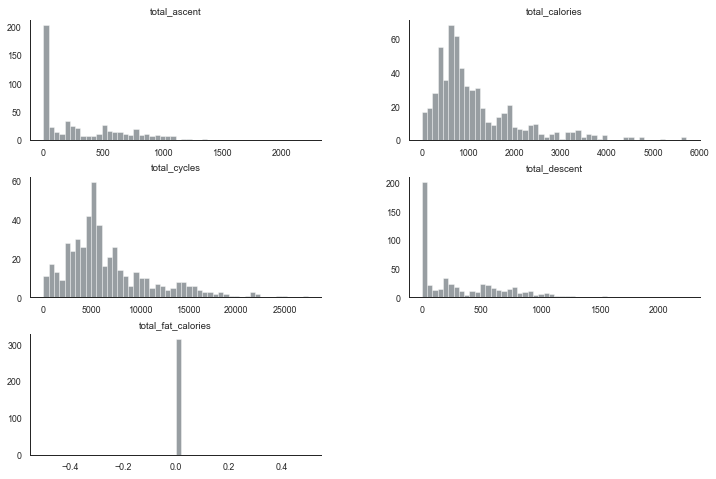

In [902]:
# explore totals pt1
explore_report(
    rides,
    ['total_ascent',
     'total_descent',         
     'total_cycles', 
     'total_calories',
     'total_fat_calories']
)

Explore **totals** (pt2)

* Good coverage
* `total_elapsed_time` is highly skewed due to the `27` outlying values, which should be removed
* `total_distance` and `total_timer_time` also have outlying values that should be removed, but these features have minimal skew

+-------+------------------+----------------------+--------------------+
|       |   total_distance |   total_elapsed_time |   total_timer_time |
|-------+------------------+----------------------+--------------------|
| count |           628.00 |               628.00 |             628.00 |
| mean  |         38136.23 |             16923.31 |            5571.79 |
| std   |         33924.77 |             98511.40 |            4080.81 |
| min   |             0.00 |                 0.67 |               0.67 |
| 25%   |          9041.35 |              2987.90 |            2734.45 |
| 50%   |         31701.35 |              4200.18 |            4091.18 |
| 75%   |         53002.00 |              8345.99 |            7190.24 |
| max   |        164129.56 |           1721086.11 |           27256.93 |
+-------+------------------+----------------------+--------------------+
+----------+------------------+----------------------+--------------------+
|          |   total_distance |   total_elapsed_

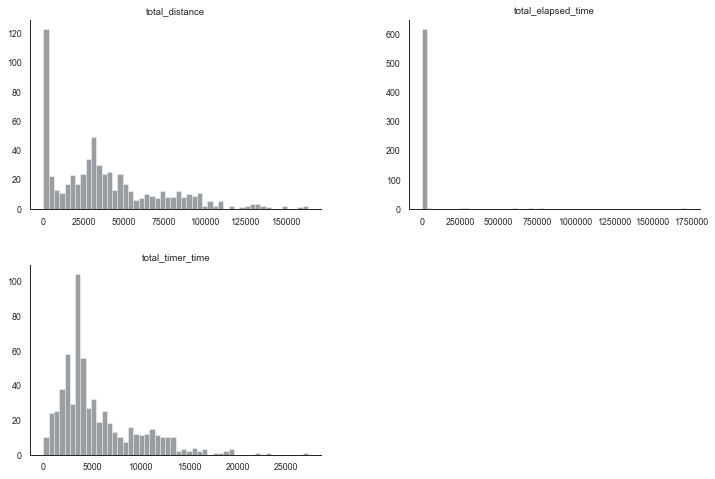

In [903]:
# explore totals pt2
explore_report(
    rides,
    ['total_distance', 
     'total_elapsed_time',
     'total_timer_time']
)

## Data Preprocessing
* Documentation of feature selection & transformation steps
* Have any abnormalities or characteristics found during data exploration been properly corrected? 

Dataset size with outliers removed: 572
+-------+-------------+----------------------+-------------------------+
|       |   max_power |   total_elapsed_time |   training_stress_score |
|-------+-------------+----------------------+-------------------------|
| count |      261.00 |               572.00 |                  259.00 |
| mean  |      421.84 |              5256.85 |                   86.05 |
| std   |      177.99 |              3668.23 |                   49.77 |
| min   |       64.00 |                 0.67 |                    0.00 |
| 25%   |      292.00 |              2744.55 |                   49.10 |
| 50%   |      346.00 |              3902.76 |                   82.10 |
| 75%   |      556.00 |              6586.34 |                  110.95 |
| max   |      877.00 |             16316.16 |                  200.70 |
+-------+-------------+----------------------+-------------------------+
+----------+-------------+----------------------+-------------------------+
|       

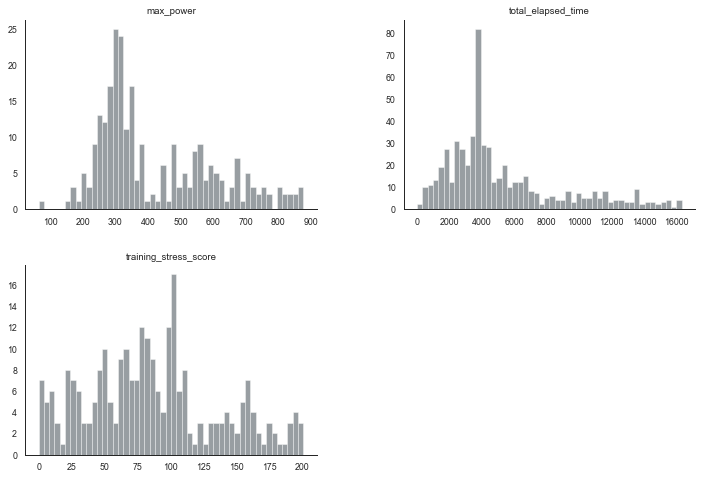

In [904]:
rides_clean = pd.DataFrame(data=rides, copy=True)

# Drop unwanted variables
rides_clean.drop(
    ['enhanced_avg_speed', 'enhanced_max_speed', 'threshold_power', 'total_fat_calories'], 
    axis=1, errors='ignore', inplace=True
)

# Remove outliers using Tukey's method
# Note:
#   Removing examples that contain a single outlying value reduces the size 
#   of the data set from 628 to 334 examples. For now, simply remove outliers 
#   that are causing significant skew.
skewed = ['max_power', 'total_elapsed_time', 'training_stress_score']
outliers = []
for series in skewed:
    outliers += fliers(rides_clean[series]).index.tolist()
rides_clean = rides_clean.drop(rides_clean.index[outliers])

print('Dataset size with outliers removed: {}'.format(len(rides_clean)))

# Skew is significantly reduced by removing outliers
explore_report(rides_clean, skewed)

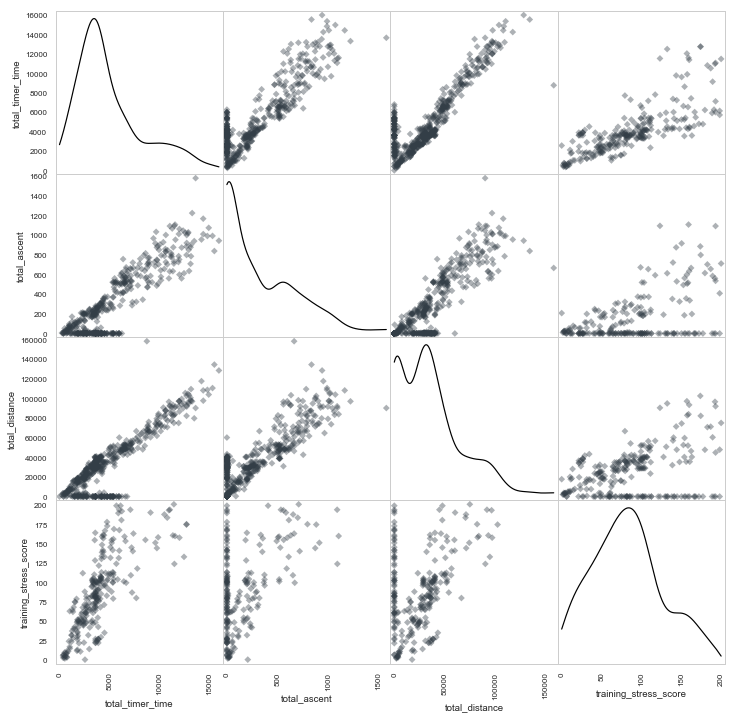

In [905]:
from pandas.plotting import scatter_matrix

v = [
    'total_timer_time',
    'total_ascent',
    'total_distance', 
    'training_stress_score'
]

axes = scatter_matrix(
    rides_clean[v], 
    alpha=0.4, 
    figsize=(12, 12), 
    diagonal='kde', 
    color='#333e47', 
    density_kwds={'color': '#000000'},
    marker='D'
)

for ax in axes:
    for x in ax:
        x.spines['top'].set_color('#cdcdcd')
        x.spines['right'].set_color('#cdcdcd')
        x.spines['bottom'].set_color('#cdcdcd')
        x.spines['left'].set_color('#cdcdcd')
plt.show()

In [906]:
# Log-transform the skewed features
print(rides_clean.skew(axis=0, numeric_only=True))

# skewed = ['avg_cadence', 'avg_heart_rate', 'max_heart_rate']
# ride_log = pd.DataFrame(data=rides_clean, copy=True)
# ride_log[skewed] = ride_log[skewed].apply(lambda x: np.log(x+1))
# print(ride_log[skewed].skew(axis=0, numeric_only=True))

# Log transforming features with a skew greater than ±2 increases the skew!
# What are the alternate methods?

avg_cadence             -2.973181
avg_heart_rate          -3.342761
avg_power               -0.792136
avg_speed               -0.898584
ftp                      0.593022
id                      -0.233755
intensity_factor        -0.509714
max_cadence              1.498481
max_heart_rate          -4.245234
max_power                0.800262
max_speed               -0.614235
normalized_power        -0.997142
total_ascent             0.963222
total_calories           1.553650
total_cycles             1.155557
total_descent            0.963923
total_distance           0.918869
total_elapsed_time       1.204489
total_timer_time         1.156420
training_stress_score    0.368625
dtype: float64


**Automated Feature Engineering**

Automate the feature engineering process using _**Deep Feature Synthesis**_:
* https://docs.featuretools.com/automated_feature_engineering/afe.html
* http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf

In [907]:
import featuretools as ft
print('Featuretools version: {}'.format(ft.__version__))

es = ft.EntitySet(id='ftp_proba')

# Add athletes entity
es = es.entity_from_dataframe(
    entity_id = 'athletes',
    dataframe = athletes[['id', 'sex', 'weight']],
    index = 'id',
    variable_types = {
        'id': ft.variable_types.Index,
        'sex': ft.variable_types.Categorical,
        'weight': ft.variable_types.Numeric
    }
)

# Add rides entity
es = es.entity_from_dataframe(
    entity_id = 'rides',
    dataframe = rides_clean,
    index = 'ride_id',
    make_index = True,
    time_index = 'timestamp'
)

# Link rides to athletes by athlete id
# Note: double check index matches
rel = ft.Relationship(
    es['athletes']['id'],
    es['rides']['id']
)
es = es.add_relationship(rel)
es.add_last_time_indexes()
print(es)

# DFS creates a row in the feature matrix for every id-time pair in the cutoff_time dataframe
# https://docs.featuretools.com/automated_feature_engineering/handling_time.html
cutoff_dt = es['rides'].df[['ride_id', 'timestamp', 'ftp']]

# Seed features allow domain specific knowledge to be included in the feature generation
# In this case we want to highlight rides with a TSS (stress) score above the IQR (75th percentile):
# https://docs.featuretools.com/guides/tuning_dfs.html
seed_tss = ft.Feature(es['rides']['training_stress_score']) > 141.5

matrix, defs = ft.dfs(
    entityset = es,
    target_entity = 'rides',
    cutoff_time = cutoff_dt,
    training_window = '183 days',
    seed_features = [
        seed_tss
    ],
    agg_primitives = [        
        'avg_time_between',
        'count',
        'mean',
        'percent_true',
        'trend'
    ],
    trans_primitives = [],
    drop_contains = [
        'rides.ftp'
    ],
    drop_exact = [
        'id',
        'ftp'
    ],
    max_depth = 2,
    verbose = True
    # features_only = True
)

Featuretools version: 0.3.1
Entityset: ftp_proba
  Entities:
    athletes [Rows: 3, Columns: 3]
    rides [Rows: 572, Columns: 22]
  Relationships:
    rides.id -> athletes.id
Built 60 features

Elapsed: 00:00 | Remaining: ? | Progress:   0%|          | Calculated: 0/11 chunks
Elapsed: 00:15 | Remaining: 02:31 | Progress:   9%|▉         | Calculated: 1/11 chunks
Elapsed: 00:26 | Remaining: 02:06 | Progress:  18%|█▊        | Calculated: 2/11 chunks
Elapsed: 00:35 | Remaining: 01:40 | Progress:  27%|██▋       | Calculated: 3/11 chunks
Elapsed: 00:44 | Remaining: 01:20 | Progress:  36%|███▋      | Calculated: 4/11 chunks
Elapsed: 00:53 | Remaining: 01:04 | Progress:  45%|████▌     | Calculated: 5/11 chunks
Elapsed: 01:03 | Remaining: 00:52 | Progress:  55%|█████▍    | Calculated: 6/11 chunks
Elapsed: 01:13 | Remaining: 00:40 | Progress:  64%|██████▎   | Calculated: 7/11 chunks
Elapsed: 01:22 | Remaining: 00:30 | Progress:  73%|███████▎  | Calculated: 8/11 chunks
Elapsed: 01:31 | Remaining

In [908]:
matrix.fillna(0, inplace=True)

# One-hot encode the categorical features
# This is actually not required as there is no data for female athletes and the feature is removed by the next step
# matrix_enc, defs_enc = ft.encode_features(matrix, defs, to_encode = ['athletes.sex'])

# Select features that have at least 2 unique values and that are not all null
from featuretools.selection import remove_low_information_features
matrix_final, defs_final = remove_low_information_features(matrix, defs)

print('Number of features: {}'.format(len(defs_final)))
print(*defs_final, sep='\n')

Number of features: 59
<Feature: avg_cadence>
<Feature: avg_heart_rate>
<Feature: avg_power>
<Feature: avg_speed>
<Feature: intensity_factor>
<Feature: max_cadence>
<Feature: max_heart_rate>
<Feature: max_power>
<Feature: max_speed>
<Feature: normalized_power>
<Feature: total_ascent>
<Feature: total_calories>
<Feature: total_cycles>
<Feature: total_descent>
<Feature: total_distance>
<Feature: total_elapsed_time>
<Feature: total_timer_time>
<Feature: training_stress_score>
<Feature: training_stress_score > 141.5>
<Feature: athletes.weight>
<Feature: athletes.AVG_TIME_BETWEEN(rides.timestamp)>
<Feature: athletes.COUNT(rides)>
<Feature: athletes.MEAN(rides.avg_cadence)>
<Feature: athletes.MEAN(rides.avg_heart_rate)>
<Feature: athletes.MEAN(rides.avg_power)>
<Feature: athletes.MEAN(rides.avg_speed)>
<Feature: athletes.MEAN(rides.intensity_factor)>
<Feature: athletes.MEAN(rides.max_cadence)>
<Feature: athletes.MEAN(rides.max_heart_rate)>
<Feature: athletes.MEAN(rides.max_power)>
<Feature: a

In [909]:
from sklearn.preprocessing import StandardScaler

y = matrix_final['ftp']
X = pd.DataFrame(data=matrix_final, copy=True)
X.drop('ftp', axis=1, inplace=True)

# Standardise features by removing the mean and scaling to unit variance
num_col = list(X.select_dtypes(include=np.number))
X[num_col] = StandardScaler().fit_transform(X[num_col])

print(X.shape)
print(y.shape)

(572, 59)
(572,)


**Ideas for further analysis:**
* Use PCA to discover the dimensions that maximise the variance of features
* Apply clustering techniques to discover whether there are different types of rides (e.g. commuting vs training vs coffee rides)

## Implementation

In [910]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 75/25 train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=14
)

k = X_train.shape[1]

print('Number of training examples: {}'.format(X_train.shape))
print('Number of test examples: {}'.format(X_test.shape))
print('Number of features: {}'.format(k))

Number of training examples: (429, 59)
Number of test examples: (143, 59)
Number of features: 59


In [911]:
def plot_linear(y_test, y_pred, title=''):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(y_test, y_pred, c='#333e47')
    ax.plot(
        [y_test.min(), y_test.max()], 
        [y_test.min(), y_test.max()], 
        'k--', lw=1, color='#000000'
    )
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(title)
    plt.show()

def r2_adj(y_test, y_pred, r2, k):
    # https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2
    n = len(y_test)
    return 1 - (1-r2)*(n-1)/(n-k-1)

def scores(y_test, y_pred, k):
    # R^2 (coefficient of determination)
    #   Measure of how close the data fits the regression line.
    #   I.e. How well observed values are replicated by the model
    r2 = r2_score(y_test, y_pred)
    
    # R^2 adjusted
    #   R^2 score (r2) suffers from a spuriously increasing score as more independent variables 
    #   are added to the model. Consequently, a model with more features may appear to have a 
    #   better fit simply because it has more features. The adjusted R^2 score takes the number 
    #   of features into account, and penalises the score if the independent variables don't 
    #   affect the dependent variable.
    R2 = r2_adj(y_test, y_pred, r2, k)
    
    mse = mean_squared_error(y_test, y_pred)
    
    print('Mean squared error: {:.2f}'.format(mse))
    print('R^2 score: {:.2f}'.format(r2))
    print('R^2 (adjusted) score: {:.2f}'.format(R2))

Mean squared error: 450.30
R^2 score: 0.65
R^2 (adjusted) score: 0.40


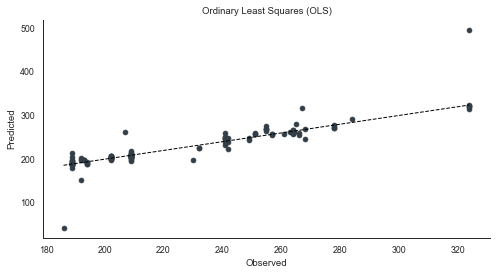

In [912]:
# Linear Regression (Ordinary Least Squares)
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

ols_pred = ols.predict(X_test)

scores(y_test, ols_pred, k)
plot_linear(y_test, ols_pred, 'Ordinary Least Squares (OLS)')

Mean squared error: 168.12
R^2 score: 0.87
R^2 (adjusted) score: 0.78
Best alpha: 1.0000


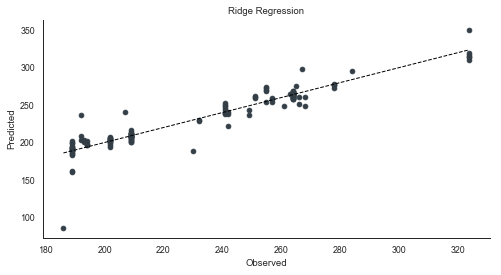

In [913]:
# Ridge Regression
#   OLS with an imposed penalty on the size of coefficients - "L2" regularisation

# RidgeCV has built-in cross-validation to find the optimal value of the alpha parameter
# (alternate approach to GridSearchCV)
ridge = linear_model.RidgeCV(alphas=np.linspace(0.5, 10., num=20), cv=5)
# ridge = linear_model.Ridge()
ridge.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)

scores(y_test, ridge_pred, k)
print('Best alpha: {:.4f}'.format(ridge.alpha_))
plot_linear(y_test, ridge_pred, 'Ridge Regression')

Mean squared error: 186.17
R^2 score: 0.86
R^2 (adjusted) score: 0.75
Best alpha: 0.5000


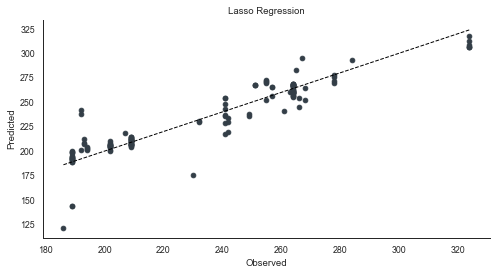

In [914]:
# Lasso

# Lasso, or "L1" regularisation results in less important features having a coefficient
# close or equal to zero (i.e. built-in feature selection).
# See: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c

# Best model is selected by cross-validation
lasso = linear_model.LassoCV(alphas=np.linspace(0.5, 10., num=20), cv=5, tol=0.001, max_iter=3000)
lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)

scores(y_test, lasso_pred, k)
print('Best alpha: {:.4f}'.format(lasso.alpha_))
plot_linear(y_test, lasso_pred, 'Lasso Regression')

Mean squared error: 164.11
R^2 score: 0.87
R^2 (adjusted) score: 0.78
Best alpha: 0.0145
Best lambda: 0.0037


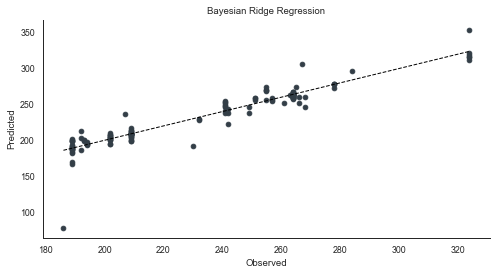

In [915]:
# Bayesian Ridge Regression

# Bayesian approach to finding the optimal values for the regularization parameters:
#   * alpha (precision of the noise)
#   * lambda (precision of the weights)
#
# The prior for the coefficients is given as a spherical Gaussian, and the priors for
# alpha and lambda are given as gamma distributions.
#
# The estimation of the parameters is done by iteratively maximising the marginal
# log-likelihood of the observations.

bayes = linear_model.BayesianRidge(compute_score=True)
bayes.fit(X_train, y_train)

pred_mean, pred_std = bayes.predict(X_test, return_std=True)

scores(y_test, pred_mean, k)
print('Best alpha: {:.4f}'.format(bayes.alpha_))
print('Best lambda: {:.4f}'.format(bayes.lambda_))
plot_linear(y_test, pred_mean, 'Bayesian Ridge Regression')

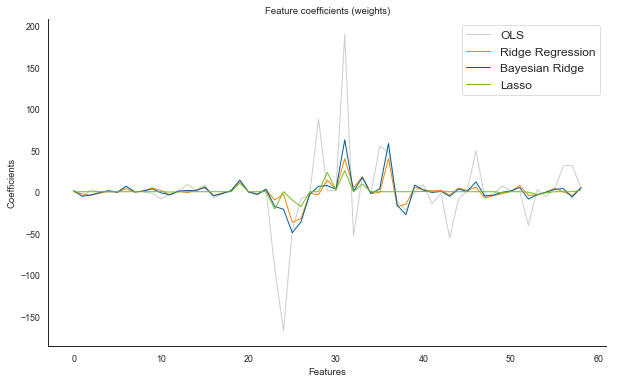

In [916]:
# Feature coefficients comparison
# In the Bayesian case the coefficients are the mean of distribution

plt.figure(figsize=(10, 6))
plt.title('Feature coefficients (weights)')
plt.plot(ols.coef_, c='#cdcdcd', linewidth=1, label='OLS')
plt.plot(ridge.coef_, c='#ff8300', linewidth=1, label='Ridge Regression')
plt.plot(bayes.coef_, c='#00609b', linewidth=1, label='Bayesian Ridge')
plt.plot(lasso.coef_, c='#76bc21', linewidth=1, label='Lasso')
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.legend(loc='best', prop=dict(size=12))

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Results (Bayesian Ridge Regression)

In [917]:
# Sensitivity analysis

for i in range(1, 10):
    Xn, Xt, yn, yt = train_test_split(X, y)

    model = linear_model.BayesianRidge(compute_score=True)
    model.fit(Xn, yn)

    pred = model.predict(Xt)
    
    r2 = r2_score(yt, pred)        
    R2 = r2_adj(yt, pred, r2, k)    
    mse = mean_squared_error(yt, pred)
    
    print('mse:{:.4f}, r2:{:.4f}, R2:{:.4f}, alpha:{:.4f}, lambda:{:.4f}'.format(
        mse, r2, R2, model.alpha_, model.lambda_    
    ))

mse:499.9880, r2:0.6490, R2:0.3996, alpha:0.0180, lambda:0.0023
mse:185.8468, r2:0.8743, R2:0.7849, alpha:0.0175, lambda:0.0037
mse:172.8634, r2:0.8828, R2:0.7995, alpha:0.0170, lambda:0.0033
mse:91.2502, r2:0.9353, R2:0.8894, alpha:0.0141, lambda:0.0035
mse:1274.6182, r2:0.1949, R2:-0.3775, alpha:0.0163, lambda:0.0031
mse:263.7643, r2:0.7935, R2:0.6467, alpha:0.0153, lambda:0.0032
mse:230.9606, r2:0.8516, R2:0.7460, alpha:0.0184, lambda:0.0028
mse:169.8603, r2:0.8774, R2:0.7903, alpha:0.0167, lambda:0.0037
mse:1039.2709, r2:0.3174, R2:-0.1678, alpha:0.0204, lambda:0.0016


In [918]:
athlete_rides = es['rides'].df[['id', 'ride_id', 'timestamp']]

out = pd.DataFrame(data=X_test, copy=True)
out = out.merge(athlete_rides, how='left', left_index=True, right_on='ride_id')
out['ftp_obsv'] = y_test
out['ftp_pred'] = pred_mean
out['ftp_std'] = pred_std
out['ftp_diff'] = out.apply(lambda x: x.ftp_pred-x.ftp_obsv, axis=1)
out['ftp_perc'] = out.apply(lambda x: 100-100/x.ftp_pred*x.ftp_obsv, axis=1)
out = out.sort_values('timestamp')

print(tab(
    out[['ftp_obsv', 'ftp_pred', 'ftp_std', 'ftp_diff', 'ftp_perc']].describe(percentiles=[.25,.75,.90]), 
    headers='keys', tablefmt='psql', floatfmt='.2f'
))

print(tab(
    out[['id', 'timestamp', 'ftp_obsv', 'ftp_pred', 'ftp_std', 'ftp_diff', 'ftp_perc']],
    headers='keys', tablefmt='psql', floatfmt='.2f'
))

+-------+------------+------------+-----------+------------+------------+
|       |   ftp_obsv |   ftp_pred |   ftp_std |   ftp_diff |   ftp_perc |
|-------+------------+------------+-----------+------------+------------|
| count |     143.00 |     143.00 |    143.00 |     143.00 |     143.00 |
| mean  |     233.11 |     233.01 |      9.74 |      -0.10 |      -0.80 |
| std   |      36.00 |      38.70 |      5.60 |      12.86 |      12.23 |
| min   |     186.00 |      78.09 |      8.44 |    -107.91 |    -138.17 |
| 25%   |     202.00 |     201.63 |      8.55 |      -3.46 |      -1.42 |
| 50%   |     241.00 |     236.42 |      8.66 |       0.03 |       0.01 |
| 75%   |     264.00 |     261.44 |      8.90 |       3.95 |       1.95 |
| 90%   |     266.00 |     270.40 |      9.55 |      11.10 |       4.88 |
| max   |     324.00 |     353.95 |     63.32 |      39.05 |      12.76 |
+-------+------------+------------+-----------+------------+------------+
+-----+---------+---------------------

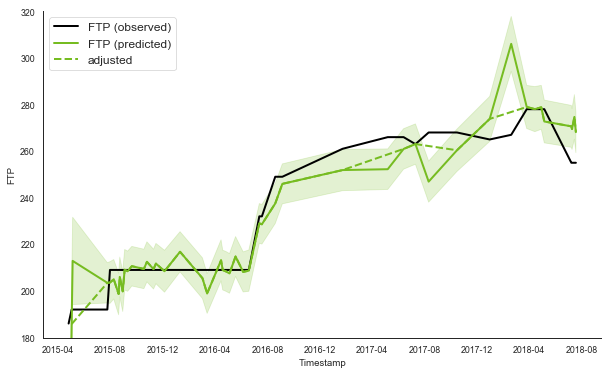

+-----+---------+---------------------+------------+------------+-----------+------------+------------+
|     |      id | timestamp           |   ftp_obsv |   ftp_pred |   ftp_std |   ftp_diff |   ftp_perc |
|-----+---------+---------------------+------------+------------+-----------+------------+------------|
|  31 | 2163639 | 2015-05-03 11:02:42 |        192 |     185.77 |     17.40 |      -6.23 |      -3.35 |
| 129 | 2163639 | 2015-07-25 10:30:14 |        192 |     203.47 |      8.65 |      11.47 |       5.63 |
| 156 | 2163639 | 2015-07-31 12:32:31 |        209 |     203.59 |      8.95 |      -5.41 |      -2.66 |
| 144 | 2163639 | 2015-08-09 08:02:55 |        209 |     204.99 |      8.48 |      -4.01 |      -1.95 |
|  38 | 2163639 | 2015-08-20 15:54:53 |        209 |     198.67 |      8.94 |     -10.33 |      -5.20 |
|  74 | 2163639 | 2015-08-23 07:56:15 |        209 |     206.02 |      8.51 |      -2.98 |      -1.45 |
| 192 | 2163639 | 2015-08-30 05:32:00 |        209 |     199.80 

In [919]:
dr = out[out.id == 6377876]
ah = out[out.id == 2163639]
ah_fixed = ah.drop([1,6,44,78,131])

plt.figure(figsize=(10, 6))
plt.title('')
plt.plot(ah.timestamp, ah.ftp_obsv, c='#000000', linewidth=2, label='FTP (observed)')
plt.plot(ah.timestamp, ah.ftp_pred, c='#76bc21', linewidth=2, label='FTP (predicted)')
plt.plot(ah_fixed.timestamp, ah_fixed.ftp_pred, c='#76bc21', linestyle='--', linewidth=2, label='adjusted')
plt.fill_between(
    ah.timestamp.values, 
    (ah.ftp_pred - ah.ftp_std), 
    (ah.ftp_pred + ah.ftp_std),
    alpha=.2,
    color='#76bc21'
)
plt.xlabel('Timestamp')
plt.ylabel('FTP')
plt.legend(loc='best', prop=dict(size=12))

ax = plt.gca()
ax.set_ylim([180,320])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

print(tab(
    ah_fixed[['id', 'timestamp', 'ftp_obsv', 'ftp_pred', 'ftp_std', 'ftp_diff', 'ftp_perc']],
    headers='keys', tablefmt='psql', floatfmt='.2f'
))

Number of features: 59
+------------------------------------------------------------+----------+
| athletes.MEAN(rides.normalized_power)                      |  62.5433 |
| athletes.MEAN(rides.total_distance)                        |  58.1310 |
| athletes.MEAN(rides.total_calories)                        |  17.2984 |
| athletes.weight                                            |  13.9814 |
| athletes.TREND(rides.total_ascent, timestamp)              |  11.8815 |
| athletes.MEAN(rides.training_stress_score)                 |   8.0388 |
| athletes.MEAN(rides.max_power)                             |   7.4344 |
| max_heart_rate                                             |   6.6081 |
| athletes.MEAN(rides.max_heart_rate)                        |   6.5043 |
| total_elapsed_time                                         |   5.7632 |
| athletes.TREND(rides.total_cycles, timestamp)              |   5.0078 |
| athletes.PERCENT_TRUE(rides.training_stress_score > 141.5) |   4.8054 |
| athletes.TREN

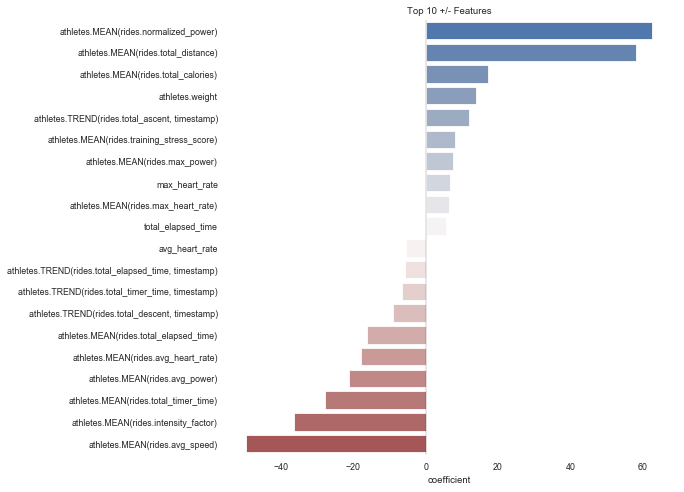

In [920]:
# Feature importances   
import seaborn as sns
sns.set(style='white', palette='muted', color_codes=True)
sns.set_context('paper')

print('Number of features: {}'.format(X.shape[1]))
coef_map = zip(list(X), bayes.coef_)
coef_rank = sorted(coef_map, key=lambda x: x[1], reverse=True)
print(tab(coef_rank, tablefmt='psql', floatfmt='.4f'))

top_df = pd.DataFrame(coef_rank, columns=['feature', 'score'])
top = top_df.head(10)
top = top.append(top_df.tail(10))

plt.figure(figsize=(8,8))

sns.barplot(
    x = top['score'], 
    y = top['feature'],
    orient = 'h',
    palette = 'vlag'
)
 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.axvline(0, color='k', lw=.2)
ax.set_ylabel('')
ax.set_xlabel('coefficient')

plt.title('Top 10 +/- Features')
plt.show()